In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers,optimizers
import numpy as np
import keras
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D
from keras.layers import Input, Add, Dropout, Permute, add

import copy
import math
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

Using TensorFlow backend.


In [2]:
input_image = Input(shape = (512,512,3))

# Block 1
layer_1 = Convolution2D(64, (3, 3), activation='relu', padding='same', name='Conv1Block1')(input_image)
layer_2 = Convolution2D(64, (3, 3), activation='relu', padding='same', name='Conv2Block1')(layer_1)
layer_3 = MaxPooling2D((2, 2), strides=(2, 2), name='MaxPoolBlock1')(layer_2)


# Block 2
layer_4 = Convolution2D(128, (3, 3), activation='relu', padding='same', name='Conv1Block2')(layer_3)
layer_5 = Convolution2D(128, (3, 3), activation='relu', padding='same', name='Conv2Block2')(layer_4)
layer_6 = MaxPooling2D((2, 2), strides=(2, 2), name='MaxPoolBlock2')(layer_5)

#Block 3
layer_7 = Convolution2D(256, (3, 3), activation='relu', padding='same', name='Conv1Block3')(layer_6)
layer_8 = Convolution2D(256, (3, 3), activation='relu', padding='same', name='Conv2Block3')(layer_7)
layer_9 = Convolution2D(256, (3, 3), activation='relu', padding='same', name='Conv3Block3')(layer_8)
layer_10 = MaxPooling2D((2, 2), strides=(2, 2), name='MaxPoolBlock3')(layer_9)

#Block 4
layer_11 = Convolution2D(512, (3, 3), activation='relu', padding='same', name='Conv1Block4')(layer_10)
layer_12 = Convolution2D(512, (3, 3), activation='relu', padding='same', name='Conv2Block4')(layer_11)
layer_13 = Convolution2D(512, (3, 3), activation='relu', padding='same', name='Conv3Block4')(layer_12)
layer_14 = MaxPooling2D((2, 2), strides=(2, 2), name='MaxPoolBlock4')(layer_13)

#Block 5
layer_15 = Convolution2D(512, (3, 3), activation='relu', padding='same', name='Conv1Block5')(layer_14)
layer_16 = Convolution2D(512, (3, 3), activation='relu', padding='same', name='Conv2Block5')(layer_15)
layer_17 = Convolution2D(512, (3, 3), activation='relu', padding='same', name='Conv3Block5')(layer_16)
layer_18 = MaxPooling2D((2, 2), strides=(2, 2), name='MaxPoolBlock5')(layer_17)

#Making the network fully convolutional 
layer_19 = Convolution2D(4096,kernel_size=(7,7),padding = "same",activation = "relu",name = "FullConv1")(layer_18)
layer_20 = Convolution2D(4096,kernel_size=(1,1),padding = "same",activation = "relu",name = "FullConv2")(layer_19)

#For obtaining the semantic segmentation scores
layer_21 = Convolution2D(21,kernel_size=(1,1),padding="same",activation="relu",name = "Score1")(layer_20)

layer_22 = Deconvolution2D(21,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "Score2")(layer_21)

#Cropping the image to make it compatible for addition 
layer_23 = Cropping2D(cropping=((0,2),(0,2)))(layer_22)

#Adding a skip connection
skip_con = Convolution2D(21,kernel_size=(1,1),padding = "same",activation=None, name = "SkipConn")

#Adding the layers
summed = add(inputs = [skip_con(layer_14),layer_23])

#Upsampling the output 
layer_24 = Deconvolution2D(21,kernel_size=(32,32),strides = (16,16),padding = "valid",activation = None,name = "Upsampled")

#Cropping the output to match the input size
crop = Cropping2D(cropping = ((0,16),(0,16)))

#Defining the model with the layers
model = Model(inputs = input_image, outputs = crop(layer_24(summed)))



    

In [3]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
Conv1Block1 (Conv2D)             (None, 512, 512, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
Conv2Block1 (Conv2D)             (None, 512, 512, 64)  36928       Conv1Block1[0][0]                
____________________________________________________________________________________________________
MaxPoolBlock1 (MaxPooling2D)     (None, 256, 256, 64)  0           Conv2Block1[0][0]                
___________________________________________________________________________________________

In [4]:
model.load_weights("weights.h5")

In [5]:
test_image = Image.open('TestingImages/2007_000170.jpg')  
test_image = test_image.resize((512,512))

In [6]:
image_arr = np.array(test_image).astype(np.float32)
image_arr = np.expand_dims(image_arr, axis=0)
preds=model.predict(image_arr)

In [16]:
print(preds.shape)
print(preds[0][0][0])
print(np.argmax(preds[0][0][0]))

(1, 512, 512, 21)
[  1.59944664e-03  -9.88819083e-05  -3.15884681e-04  -8.87085858e-04
   1.01314671e-03  -5.75705315e-04   7.82577088e-04   9.52466275e-04
  -1.33699959e-03   3.09682684e-04  -2.45740812e-04   4.93840664e-04
  -2.00235005e-03  -6.69253466e-04   1.36807366e-05  -9.11422248e-04
  -7.92830775e-04  -7.11615256e-04   1.59212318e-03   1.69945357e-03
   7.20309967e-04]
19


In [18]:
print(np.argmax(preds,axis=3)[0,:,:])

[[19 19 19 ...,  0  0  0]
 [19 19 19 ...,  0  0  0]
 [19 19 19 ...,  0  0  0]
 ..., 
 [19 19 19 ...,  0  0  0]
 [19 19 19 ...,  0  0  0]
 [19 19 19 ...,  0  0  0]]


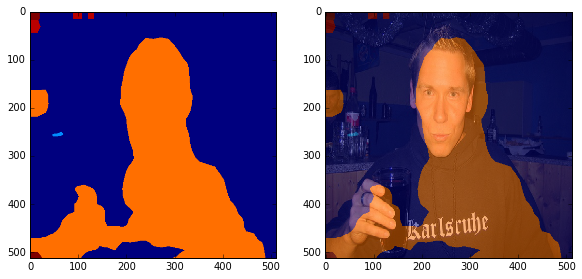

In [7]:
imclass = np.argmax(preds, axis=3)[0,:,:]
plt.figure(figsize = (15, 7))
#plt.subplot(1,3,1)
#plt.imshow( np.asarray(test_image) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(test_image) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
plt.imshow( imclass, alpha=0.5 )

In [40]:
max_val = -1
ind = 0
for i in range(1,21):
    if list(imclass.flatten()).count(i)>max_val:
        ind = i
        max_val = list(imclass.flatten()).count(i)

In [42]:
np.set_printoptions(threshold='nan')
print(imclass)
print(type(imclass))
print(ind)

[[19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 18 18 18 18 18 18 18
  18 18 18 18 18 18 18 18 18 18 18 18  0  0  0  0  0  0  0  0  0  0  0  0
  18 18 18 18 18 18 18 18 18 18 18 18 18  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0 

In [43]:
for i in range(512):
    for j in range(512):
        if imclass[i][j]!=ind:
            imclass[i][j]=0

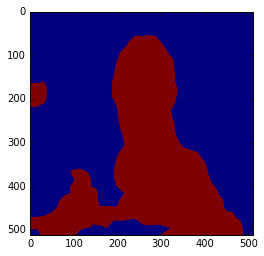

In [44]:
imgplot = plt.imshow(imclass)
plt.show()

In [32]:
test_image = Image.open('TestingImages/2007_000241.jpg')  
test_image = test_image.resize((512,512))

In [34]:
image_arr = np.array(test_image).astype(np.float32)
image_arr = np.expand_dims(image_arr, axis=0)
preds=model.predict(image_arr)

(1, 512, 512, 21)


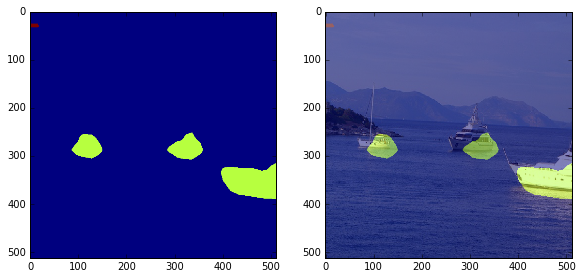

In [37]:
print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
plt.figure(figsize = (15, 7))
#plt.subplot(1,3,1)
#plt.imshow( np.asarray(test_image) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(test_image) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
plt.imshow( imclass, alpha=0.5 )

(512, 512, 3)
(1, 512, 512, 21)


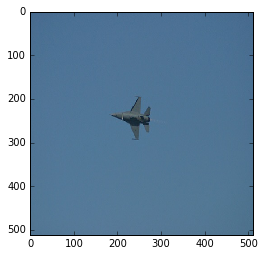

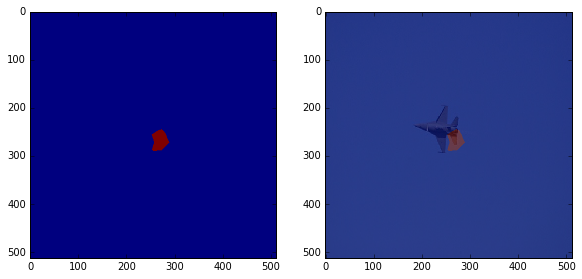

In [39]:
%matplotlib inline
test_image = Image.open('TestingImages/2007_000243.jpg')  
test_image = test_image.resize((512,512))

image_arr = np.array(test_image).astype(np.float32)
image_arr = np.expand_dims(image_arr, axis=0)
preds=model.predict(image_arr)

print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
plt.figure(figsize = (15, 7))
#plt.subplot(1,3,1)
#plt.imshow( np.asarray(test_image) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(test_image) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
plt.imshow( imclass, alpha=0.5 )